<a href="https://colab.research.google.com/github/ZhangTaTa/keras_learning/blob/master/img_cls_transfer_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

【数据格式】

本代码原始数据为上传至Google drive的npy文件。

经过分组、预处理后可进入神经网络。

In [ ]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

np.random.seed(1337)  # for reproducibility

Using TensorFlow backend.


In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(100, 100, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

加载数据

In [ ]:
X = np.load("./drive/My Drive/DLdata/imgDataMatrix.npy", allow_pickle=True)
Y = np.load("./drive/My Drive/DLdata/imgClassMatrix.npy", allow_pickle=True)
name_list = np.load("./drive/My Drive/DLdata/imgNameMatrix.npy")

In [ ]:
print(X.shape)
print(Y.shape)
print(name_list.shape)

(3647, 30000)
(3647, 1)
(3647, 1)
<class 'numpy.int32'>


随机分类train、validation和test（6:2:2）


In [ ]:
ran = np.random.random(size=(len(Y), 1))
trainList = ran > 0.4
testList = ran <= 0.2
dataRow = np.concatenate((X, Y, name_list, trainList, testList), axis=1)
X_train = dataRow[dataRow[:, X.shape[1]+2] == True][:, 0:X.shape[1]]
Y_train = dataRow[dataRow[:, X.shape[1]+2] == True][:, X.shape[1]]
X_val = dataRow[(dataRow[:, X.shape[1]+2] == False) & (dataRow[:, X.shape[1]+3] == False)][:, 0:X.shape[1]]
Y_val = dataRow[(dataRow[:, X.shape[1]+2] == False) & (dataRow[:, X.shape[1]+3] == False)][:, X.shape[1]]
X_test = dataRow[dataRow[:, X.shape[1]+3] == True][:, 0:X.shape[1]]
Y_test = dataRow[dataRow[:, X.shape[1]+3] == True][:, X.shape[1]]
NameList_test = dataRow[dataRow[:, X.shape[1]+3] == True][:, X.shape[1]+1]
NameList_test = NameList_test.reshape(len(NameList_test), 1)

数据预处理

In [ ]:
# 数据预处理（size：100×100，RGB格式）
X_train = X_train.reshape(-1, 3, 100, 100) / 255.
X_val = X_val.reshape(-1, 3, 100, 100) / 255.
X_test = X_test.reshape(-1, 3, 100, 100) / 255.
# 输入改成(100, 100, 3) 手动channels_last
X_train = np.moveaxis(X_train, 1, -1)
X_val = np.moveaxis(X_val, 1, -1)
X_test = np.moveaxis(X_test, 1, -1)

In [ ]:
print(X_train.shape[0])
print(X_val.shape)
print(X_test.shape)

2185
(745, 100, 100, 3)
(717, 100, 100, 3)


利用 ImageDataGenerator 数据增强

In [ ]:
"""
ImageDataGenerator()是keras.preprocessing.image模块中的图片生成器，同时也可以
在batch中对数据进行增强，扩充数据集大小，增强模型的泛化能力。
比如进行旋转，变形，归一化等等。
"""

datagen = ImageDataGenerator()
batch_size = 20

def extract_features(sample, label):
    sample_count = sample.shape[0]
    features = np.zeros(shape=(sample_count, 3, 3, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow(
        x=sample,
        y=label,
        batch_size=batch_size)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(X_train, Y_train)
validation_features, validation_labels = extract_features(X_val, Y_val)
test_features, test_labels = extract_features(X_test, Y_test)

In [ ]:
print(train_features.shape)
print(train_labels)

(2166, 3, 3, 512)
[1. 1. 0. ... 1. 1. 1.]


In [ ]:
# reshape features
train_features = np.reshape(train_features, (X_train.shape[0], 3 * 3 * 512))
validation_features = np.reshape(validation_features, (X_val.shape[0], 3 * 3 * 512))
test_features = np.reshape(test_features, (X_test.shape[0], 3 * 3 * 512))

模型compile

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

带验证集看一下拟合情况

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=80,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

作图看一下train和val的正确率和loss

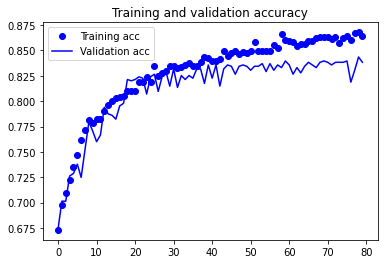

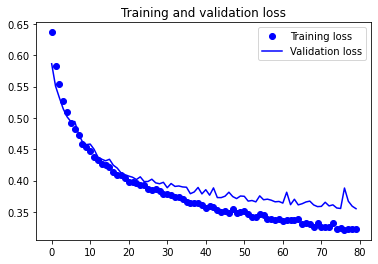

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

看看错的错在哪
争取提高到90%
VGG, RestNet, Inception
8.3 跑一跑 对应“Artistic Style”
activation visualization



正式训练

In [ ]:
history = model.fit(train_features, train_labels,
          epochs=50,
          batch_size=20)

Epoch 1/50
2185/2185 [==============================] - 2s 994us/step - loss: 0.6406 - acc: 0.6622
Epoch 2/50
2185/2185 [==============================] - 2s 952us/step - loss: 0.5778 - acc: 0.7039
Epoch 3/50
2185/2185 [==============================] - 2s 936us/step - loss: 0.5539 - acc: 0.7144
Epoch 4/50
2185/2185 [==============================] - 2s 928us/step - loss: 0.5265 - acc: 0.7286
Epoch 5/50
2185/2185 [==============================] - 2s 938us/step - loss: 0.5167 - acc: 0.7254
Epoch 6/50
2185/2185 [==============================] - 2s 929us/step - loss: 0.4988 - acc: 0.7419
Epoch 7/50
2185/2185 [==============================] - 2s 958us/step - loss: 0.4915 - acc: 0.7455
Epoch 8/50
2185/2185 [==============================] - 2s 923us/step - loss: 0.4743 - acc: 0.7538
Epoch 9/50
2185/2185 [==============================] - 2s 936us/step - loss: 0.4612 - acc: 0.7767
Epoch 10/50
2185/2185 [==============================] - 2s 935us/step - loss: 0.4557 - acc: 0.7771
Epoch 11/

测试 查看正确率和损失，查看错误样例

In [ ]:
# evaluation
loss, accuracy = model.evaluate(test_features, test_labels)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)


# 查看具体错误样例
predict_result = model.predict(test_features)
test_labels = test_labels.reshape(len(test_labels),1)
loss_tmp = abs(predict_result - test_labels)
judge = loss_tmp < 0.5
NameList_test = NameList_test.reshape(len(NameList_test), 1)
error_list = np.concatenate((NameList_test, judge), axis=1)
error_list = error_list[error_list[:, 1] == 0][:, 0]
errorItmNum = len(error_list)
print(errorItmNum)
print(error_list)

717/717 [==============================] - 0s 183us/step

test loss:  0.38101008985414997

test accuracy:  0.8131101727485657
134
[1072  118  136  139  151  194  206  211  281  284  297  307  317  322
   37  377  443  493   51  511  528  532  538  546  552  593  594  636
  659  668  726  744  749  759  763  766  817  888  917  922  924  930
  938  956  973 1179 1232 1246 1254 1260 1263 1270 1276 1356 1363 1470
 1496 1541 1561 1600 1615 1637 1681 1682 1718 1737 1744 1745 1789 1798
 1836 1845 1850 1851 1911 1962 2007 2010 2037 2096 2142 2189 2194 2246
 2267 2295 2297 2301 2311 2312 2320 2324 2335 2337 2347 2362 2374 2417
 2447 2486 2506 2607 2611 2657 2667 2687 2690 2702 2776 2811 2836 2858
 2947 2972 3023 3036 3047 3077 3087 3116 3146 3171 3188 3209 3237 3252
 3257 3263 3268 3318 3435 3467 3476 3542]


打印错误样例

In [ ]:
from PIL import Image
import math
# 图片名称集
errorNameList = []
for i in range(0, len(error_list)):
  errorNameList.append(str(error_list[i]) + ".jpg")
imgPath = "./drive/My Drive/DLdata/img_thumb/"
imgSize = 100   # 图片大小
imgCol = math.floor(math.sqrt(errorItmNum)) + 1   # 列数
if imgCol * (imgCol - 1) >= errorItmNum:
  imgRow = imgCol - 1
else:
  imgRow = imgCol   # 行数
print((str(imgCol) + " " + str(imgRow)))

# 创建新图片
to_image = Image.new('RGB', (imgCol * imgSize, imgRow * imgSize))
to_image.show()
for y in range(1, imgRow + 1):
  for x in range(1, imgCol + 1):
    if 12 * (y - 1) + x <= errorItmNum:
      from_image = Image.open(imgPath + errorNameList[imgCol * (y - 1) + x - 1]).resize(
          (imgSize, imgSize), Image.ANTIALIAS)
      to_image.paste(from_image, ((x - 1) * imgSize, (y - 1) * imgSize))
    else:
      break
to_image.save("./drive/My Drive/DLdata/errorImg.jpg")

['1072.jpg', '118.jpg', '136.jpg', '139.jpg', '151.jpg', '194.jpg', '206.jpg', '211.jpg', '281.jpg', '284.jpg', '297.jpg', '307.jpg', '317.jpg', '322.jpg', '37.jpg', '377.jpg', '443.jpg', '493.jpg', '51.jpg', '511.jpg', '528.jpg', '532.jpg', '538.jpg', '546.jpg', '552.jpg', '593.jpg', '594.jpg', '636.jpg', '659.jpg', '668.jpg', '726.jpg', '744.jpg', '749.jpg', '759.jpg', '763.jpg', '766.jpg', '817.jpg', '888.jpg', '917.jpg', '922.jpg', '924.jpg', '930.jpg', '938.jpg', '956.jpg', '973.jpg', '1179.jpg', '1232.jpg', '1246.jpg', '1254.jpg', '1260.jpg', '1263.jpg', '1270.jpg', '1276.jpg', '1356.jpg', '1363.jpg', '1470.jpg', '1496.jpg', '1541.jpg', '1561.jpg', '1600.jpg', '1615.jpg', '1637.jpg', '1681.jpg', '1682.jpg', '1718.jpg', '1737.jpg', '1744.jpg', '1745.jpg', '1789.jpg', '1798.jpg', '1836.jpg', '1845.jpg', '1850.jpg', '1851.jpg', '1911.jpg', '1962.jpg', '2007.jpg', '2010.jpg', '2037.jpg', '2096.jpg', '2142.jpg', '2189.jpg', '2194.jpg', '2246.jpg', '2267.jpg', '2295.jpg', '2297.jpg', '